In [ ]:
import os
import numpy as np

input_dir = r"raw features"
output_dir = r"output_txt"

# 子資料夾名稱
norm_dir = os.path.join(output_dir, "normalized")
nonorm_dir = os.path.join(output_dir, "non_normalized")

os.makedirs(norm_dir, exist_ok=True)
os.makedirs(nonorm_dir, exist_ok=True)

# 讀取每個類別的 txt 檔案
for filename in os.listdir(input_dir):
    if not filename.endswith(".txt"):
        continue
    filepath = os.path.join(input_dir, filename)

    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # 第一行通常是類別名稱
    class_name = lines[0].strip()
    feature_lines = lines[1:]

    # 解析特徵，假設每行最後幾欄是檔案路徑或其他非數值資訊
    features = []
    infos = []
    for line in feature_lines:
        parts = line.strip().split()
        # 數值部分假設前 478 欄
        feat = list(map(float, parts[:478]))
        info = parts[478:]  # 後面資訊保留
        features.append(feat)
        infos.append(info)

    features = np.array(features)  # shape = (201, 478)

    # ---------- 輸出非正規化 ----------
    nonorm_lines = []
    for feat, info in zip(features, infos):
        line = " ".join(map(str, feat)) + " " + " ".join(info)
        nonorm_lines.append(line)
    with open(os.path.join(nonorm_dir, filename), 'w', encoding='utf-8') as f:
        f.write(class_name + "\n")
        f.write("\n".join(nonorm_lines))

    # ---------- 輸出欄位正規化 (0-1 Min-Max) ----------
    # 對每一欄做正規化
    min_vals = features.min(axis=0)
    max_vals = features.max(axis=0)
    denom = max_vals - min_vals
    denom[denom == 0] = 1  # 避免除以零
    norm_features = (features - min_vals) / denom

    norm_lines = []
    for feat, info in zip(norm_features, infos):
        line = " ".join(map(str, feat)) + " " + " ".join(info)
        norm_lines.append(line)
    with open(os.path.join(norm_dir, filename), 'w', encoding='utf-8') as f:
        f.write(class_name + "\n")
        f.write("\n".join(norm_lines))

print("處理完成，已輸出非正規化與正規化版本")


In [ ]:
import os

normalized_dir = r"\output_txt\normalized"
unformal_dir = r"output_txt\non_normalized"

output_normal = os.path.join(normalized_dir, "fnormal.txt")
output_unformal = os.path.join(unformal_dir, "unformal.txt")

def merge_txt(input_dir, output_file):
    files = sorted(os.listdir(input_dir))
    with open(output_file, "w", encoding="utf-8") as outfile:
        for fname in files:
            if not fname.endswith(".txt"):
                continue
            class_name = os.path.splitext(fname)[0]
            with open(os.path.join(input_dir, fname), "r", encoding="utf-8") as infile:
                lines = infile.readlines()
                for line in lines:
                    # 在每一行最後加上類別名稱
                    outfile.write(line.strip() + f" {class_name}\n")
    print(f"✅ 合併完成：{output_file}")

merge_txt(normalized_dir, output_normal)
merge_txt(unformal_dir, output_unformal)


In [ ]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.stats import pearsonr
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

class ImageRetrievalSystem:
    def __init__(self, data_dir, is_normalized=True):
        """
        初始化圖像檢索系統
        data_dir: 資料目錄路徑
        is_normalized: True 使用正規化資料，False 使用非正規化資料
        """
        self.data_dir = data_dir
        self.is_normalized = is_normalized
        self.features = []
        self.labels = []
        self.image_paths = []
        self.feature_ranges = {
            'ColorStructure': (0, 32),
            'ColorLayout': (32, 44),
            'RegionShape': (44, 80),
            'HomogeneousTexture': (336, 398),
            'EdgeHistogram': (398, 478)
        }
        
    def load_data(self):
        """載入所有特徵檔案"""
        print(f"載入{'正規化' if self.is_normalized else '非正規化'}資料...")
        
        txt_files = [f for f in os.listdir(self.data_dir) if f.endswith('.txt')]
        
        for txt_file in txt_files:
            class_name = txt_file.replace('.txt', '')
            file_path = os.path.join(self.data_dir, txt_file)
            
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 478:
                    continue
                
                # 提取特徵 (前478個欄位)
                features = np.array([float(x) for x in parts[:478]])
                
                # 提取圖像路徑和標籤
                image_path = parts[-2] if len(parts) > 478 else ''
                
                self.features.append(features) #所有訊息
                self.labels.append(class_name) #圖片檔名
                self.image_paths.append(image_path) #圖片路徑
        
        self.features = np.array(self.features)
        print(f"載入完成: {len(self.features)} 張圖像")
        
    def cosine_similarity_score(self, query_idx, target_idx):
        """計算 Cosine Similarity"""
        query = self.features[query_idx].reshape(1, -1)
        target = self.features[target_idx].reshape(1, -1)
        return cosine_similarity(query, target)[0][0] 
    
    def euclidean_distance_score(self, query_idx, target_idx):
        """計算 Euclidean Distance (轉換為相似度)"""
        distance = euclidean(self.features[query_idx], self.features[target_idx])
        # 轉換為相似度：距離越小，相似度越高
        return 1 / (1 + distance)
    
    def pcc_score(self, query_idx, target_idx):
        """計算 Pearson Correlation Coefficient"""
        try:
            corr, _ = pearsonr(self.features[query_idx], self.features[target_idx])
            return corr if not np.isnan(corr) else 0
        except:
            return 0
    
    def retrieve_top_k(self, query_idx, k=10, method='cosine'):
        """
        檢索最相似的 top-k 圖像
        method: 'cosine', 'euclidean', 'pcc'
        """
        scores = []
        
        for i in range(len(self.features)):
            if i == query_idx:  # 跳過自己
                continue
            
            if method == 'cosine':
                score = self.cosine_similarity_score(query_idx, i)
            elif method == 'euclidean':
                score = self.euclidean_distance_score(query_idx, i)
            elif method == 'pcc':
                score = self.pcc_score(query_idx, i)
            else:
                raise ValueError(f"Unknown method: {method}")
            
            scores.append((i, score))
        
        # 排序並取 top-k
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:k]
    
    def calculate_accuracy(self, top_k_results, query_label):
        """計算準確率：top-k 中相同類別的比例"""
        correct = sum(1 for idx, _ in top_k_results if self.labels[idx] == query_label)
        return correct / len(top_k_results)
    
    def evaluate_all(self, k=10, methods=['cosine', 'euclidean', 'pcc']):
        """評估所有查詢圖像（優化版本）"""
        results = {method: [] for method in methods} #儲存每張圖片的 Top-K 準確率
        class_results = {method: defaultdict(list) for method in methods} #記錄每個類別的平均準確率
        # results["cosine"] = [0.8, 0.6, 1.0, ...]
        # class_results["cosine"]["Car"] = [1.0, 0.9, ...]

        print(f"\n開始評估 (Top-{k})...")
        print(f"總共 {len(self.features)} 張圖像")
        
        # 預先計算所有相似度矩陣（更快）
        from time import time
        
        for method in methods:
            print(f"\n計算 {method} 相似度...")
            start_time = time()
            
            if method == 'cosine':
                # 使用向量化計算 Cosine Similarity
                similarity_matrix = cosine_similarity(self.features)#API函式
                # 這行會得到一個 N×N 矩陣，
                # similarity_matrix[i, j] = 第 i 張與第 j 張的餘弦相似度。
                # 值越接近 1 表示越相似。
                
            elif method == 'euclidean':
                # 使用向量化計算 Euclidean Distance
                from sklearn.metrics.pairwise import euclidean_distances
                distance_matrix = euclidean_distances(self.features)
                similarity_matrix = 1 / (1 + distance_matrix) #將距離轉換為相似度（距離越小相似度越高）
                
            elif method == 'pcc':
                # 計算 Pearson Correlation
                similarity_matrix = np.corrcoef(self.features)
                similarity_matrix = np.nan_to_num(similarity_matrix, 0)
                # np.corrcoef() 會計算每兩張圖片特徵間的皮爾森相關係數。
                # 範圍為 [-1, 1]，越接近 1 表示越相關。
                # 使用 np.nan_to_num 把可能的 NaN（例如除以 0）改為 0
                
            print(f"  完成！耗時: {time() - start_time:.2f} 秒")
            print(f"  開始評估準確率...")
            
            # 對每個查詢計算準確率
            for query_idx in range(len(self.features)): #逐一取每張圖片作為查詢（Query）。
                query_label = self.labels[query_idx] #query_label 為該圖片的真實類別。
                
                # 進度顯示
                if (query_idx + 1) % 500 == 0:
                    progress = (query_idx + 1) / len(self.features) * 100
                    # print(f"    進度: {query_idx + 1}/{len(self.features)} ({progress:.1f}%)")
                
                # 取得該查詢的所有相似度
                scores = similarity_matrix[query_idx].copy()
                scores[query_idx] = -np.inf  # 排除自己
                
                # 取 Top-K
                top_k_indices = np.argsort(scores)[-k:][::-1]
                
                # 計算準確率
                correct = sum(1 for idx in top_k_indices if self.labels[idx] == query_label)
                accuracy = correct / k
                
                results[method].append(accuracy)
                class_results[method][query_label].append(accuracy)
            
            print(f"  {method} 評估完成！")
        
        return results, class_results
    
    def evaluate_by_feature_type(self, k=10, methods=['cosine', 'euclidean', 'pcc']):
        """針對不同特徵類型進行評估（優化版本）"""
        feature_results = {}
        
        for feature_name, (start, end) in self.feature_ranges.items():
            print(f"\n評估特徵: {feature_name} (維度: {end-start})")
            
            # 暫存原始特徵
            original_features = self.features.copy()
            
            # 只使用特定特徵
            self.features = original_features[:, start:end]
            
            # 使用優化後的評估方法
            results, _ = self.evaluate_all(k, methods)
            feature_results[feature_name] = results
            
            # 恢復原始特徵
            self.features = original_features
        
        return feature_results
    
    def print_summary(self, results, class_results):
        """輸出摘要統計"""
        print("\n" + "="*70)
        print(f"{'評估結果摘要':^70}")
        print("="*70)
        print(f"資料類型: {'正規化' if self.is_normalized else '非正規化'}")
        print(f"總圖像數: {len(self.features)}")
        print(f"類別數: {len(set(self.labels))}")
        print("-"*70)
        
        # 整體準確率
        print(f"\n{'方法':<20} {'平均準確率':<15} {'標準差':<15} {'最小值':<15} {'最大值':<15}")
        print("-"*70)
        
        for method, accuracies in results.items():
            mean_acc = np.mean(accuracies)
            std_acc = np.std(accuracies)
            min_acc = np.min(accuracies)
            max_acc = np.max(accuracies)
            print(f"{method:<20} {mean_acc:<15.4f} {std_acc:<15.4f} {min_acc:<15.4f} {max_acc:<15.4f}")
        
        # 各類別準確率
        print("\n" + "-"*70)
        print("各類別平均準確率 (Top 10):")
        print("-"*70)
        
        for method in results.keys():
            print(f"\n{method}:")
            class_means = {cls: np.mean(accs) for cls, accs in class_results[method].items()}
            sorted_classes = sorted(class_means.items(), key=lambda x: x[1], reverse=True)
            
            for i, (cls, acc) in enumerate(sorted_classes[:10], 1):
                print(f"  {i:2d}. {cls:<30} {acc:.4f}")
        
        print("\n" + "="*70)


def compare_normalization_effects(normalized_dir, non_normalized_dir, k=10): # main第一次呼叫
    """比較正規化與非正規化的效果"""
    
    methods = ['cosine', 'euclidean', 'pcc']
    
    overall_start_time = time()
    
    # 評估正規化資料
    print("\n" + "="*70)
    print("評估正規化資料")
    print("="*70)
    start_time = time()
    system_normalized = ImageRetrievalSystem(normalized_dir, is_normalized=True)
    system_normalized.load_data()
    results_norm, class_results_norm = system_normalized.evaluate_all(k, methods)
    print(f"\n正規化資料評估完成！總耗時: {time() - start_time:.2f} 秒")
    system_normalized.print_summary(results_norm, class_results_norm)
    
    # 評估非正規化資料
    print("\n" + "="*70)
    print("評估非正規化資料")
    print("="*70)
    start_time = time()
    system_non_norm = ImageRetrievalSystem(non_normalized_dir, is_normalized=False)
    system_non_norm.load_data()
    results_non_norm, class_results_non_norm = system_non_norm.evaluate_all(k, methods)
    print(f"\n非正規化資料評估完成！總耗時: {time() - start_time:.2f} 秒")
    system_non_norm.print_summary(results_non_norm, class_results_non_norm)
    
    print(f"\n總執行時間: {time() - overall_start_time:.2f} 秒")
    
    # 比較分析
    print("\n" + "="*70)
    print("正規化 vs 非正規化 比較分析")
    print("="*70)
    print(f"\n{'方法':<20} {'正規化準確率':<20} {'非正規化準確率':<20} {'差異':<15}")
    print("-"*70)
    
    for method in methods:
        norm_acc = np.mean(results_norm[method])
        non_norm_acc = np.mean(results_non_norm[method])
        diff = norm_acc - non_norm_acc
        print(f"{method:<20} {norm_acc:<20.4f} {non_norm_acc:<20.4f} {diff:+.4f}")
    
    # 視覺化比較
    plot_comparison(results_norm, results_non_norm, methods)
    
    return system_normalized, system_non_norm, results_norm, results_non_norm


def plot_comparison(results_norm, results_non_norm, methods):
    """繪製比較圖表"""
    
    # 準備資料
    comparison_data = []
    for method in methods:
        comparison_data.append({
            'Method': method,
            'Type': 'Normalized',
            'Accuracy': np.mean(results_norm[method])
        })
        comparison_data.append({
            'Method': method,
            'Type': 'Non-Normalized',
            'Accuracy': np.mean(results_non_norm[method])
        })
    
    df = pd.DataFrame(comparison_data)
    
    # 繪製長條圖
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    methods_list = df['Method'].unique()
    x = np.arange(len(methods_list))
    width = 0.35
    
    norm_accs = [np.mean(results_norm[m]) for m in methods_list]
    non_norm_accs = [np.mean(results_non_norm[m]) for m in methods_list]
    
    plt.bar(x - width/2, norm_accs, width, label='Normalized', alpha=0.8)
    plt.bar(x + width/2, non_norm_accs, width, label='Non-Normalized', alpha=0.8)
    
    plt.xlabel('Similarity Method')
    plt.ylabel('Average Accuracy')
    plt.title('Comparison of Accuracy by Normalization')
    plt.xticks(x, methods_list)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # 繪製箱型圖
    plt.subplot(1, 2, 2)
    data_to_plot = []
    labels_to_plot = []
    
    for method in methods:
        data_to_plot.append(results_norm[method])
        labels_to_plot.append(f'{method}\n(Norm)')
        data_to_plot.append(results_non_norm[method])
        labels_to_plot.append(f'{method}\n(Non-Norm)')
    
    bp = plt.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
    
    # 設定顏色
    colors = ['lightblue', 'lightcoral'] * len(methods)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel('Accuracy')
    plt.title('Accuracy Distribution by Method and Normalization')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
    print("\n圖表已儲存為: accuracy_comparison.png")
    plt.show()


def analyze_feature_importance(normalized_dir, k=10):
    """分析不同特徵類型的重要性"""
    print("\n" + "="*70)
    print("特徵重要性分析")
    print("="*70)
    
    system = ImageRetrievalSystem(normalized_dir, is_normalized=True)
    system.load_data()
    
    feature_results = system.evaluate_by_feature_type(k)
    
    # 輸出結果
    print("\n各特徵類型的準確率:")
    print("-"*70)
    print(f"{'特徵類型':<25} {'Cosine':<15} {'Euclidean':<15} {'PCC':<15}")
    print("-"*70)
    
    for feature_name in system.feature_ranges.keys():
        cosine_acc = np.mean(feature_results[feature_name]['cosine'])
        euclidean_acc = np.mean(feature_results[feature_name]['euclidean'])
        pcc_acc = np.mean(feature_results[feature_name]['pcc'])
        print(f"{feature_name:<25} {cosine_acc:<15.4f} {euclidean_acc:<15.4f} {pcc_acc:<15.4f}")
    
    return feature_results


# 主程式
if __name__ == "__main__":
    # 設定路徑
    normalized_dir = r"C:\Users\User\Downloads\class\114-1_電腦視覺\output_txt\normalized"
    non_normalized_dir = r"C:\Users\User\Downloads\class\114-1_電腦視覺\output_txt\non_normalized"
    
    # 比較正規化與非正規化
    # system_norm, system_non_norm, results_norm, results_non_norm = compare_normalization_effects(
    #     normalized_dir, 
    #     non_normalized_dir, 
    #     k=10
    # )
    
    # 分析特徵重要性 (使用正規化資料)
    feature_results = analyze_feature_importance(normalized_dir, k=10)
    
    print("\n" + "="*70)
    print("分析完成！")
    print("="*70)

In [ ]:
import os
import shutil

# ✅ 設定路徑
source_root = r"C:\Users\User\Downloads\pic"  # 包含所有類別資料夾的根目錄
target_dir = r"C:\Users\User\Downloads\pic\ALL_PIC"  # 目標資料夾
name_txt_path = r"name.txt"  # name.txt 路徑

# ✅ 若目標資料夾不存在則建立
os.makedirs(target_dir, exist_ok=True)

# ✅ 讀取 name.txt
print(f"讀取 name.txt: {name_txt_path}")
if not os.path.exists(name_txt_path):
    print(f"❌ 錯誤：找不到 name.txt 檔案！")
    exit(1)

with open(name_txt_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

print(f"✅ name.txt 共有 {len(lines)} 行")
print("="*70)

# ✅ 開始處理每一行
success_count = 0
fail_count = 0

for index, line in enumerate(lines, 1):
    line = line.strip()
    if not line:  # 跳過空行
        continue
    
    parts = line.split()
    if len(parts) < 2:
        print(f"⚠️  第 {index} 行格式不正確: {line}")
        fail_count += 1
        continue
    
    image_filename = parts[0]  # 例如: AncestorDinoArt_001.jpg
    class_name = parts[1]      # 例如: AncestorDinoArt
    
    # ✅ 取得副檔名
    if '.' in image_filename:
        ext = image_filename.split('.')[-1].lower()
    else:
        ext = 'jpg'  # 預設副檔名
    
    # ✅ 來源檔案路徑（在類別資料夾中）
    src = os.path.join(source_root, class_name, image_filename)
    
    # ✅ 目標檔案路徑（重新編號）
    new_name = f"{index:05d}.{ext}"
    dst = os.path.join(target_dir, new_name)
    
    # ✅ 檢查來源檔案是否存在
    if not os.path.exists(src):
        print(f"❌ 第 {index} 行：找不到檔案 {src}")
        fail_count += 1
        continue
    
    # ✅ 複製檔案
    try:
        shutil.copy2(src, dst)
        print(f"✅ {index:5d}. {image_filename:40s} → {new_name:15s} ({class_name})")
        success_count += 1
    except Exception as e:
        print(f"❌ 第 {index} 行：複製失敗 - {e}")
        fail_count += 1

print("="*70)
print(f"\n✅ 完成！")
print(f"   成功複製: {success_count} 張")
print(f"   失敗: {fail_count} 張")
print(f"   目標資料夾: {target_dir}")
print("="*70)

In [ ]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
from time import time
import cv2

class ImageRetrievalSystem:
    def __init__(self, data_dir, is_normalized=True):
        """
        初始化圖像檢索系統
        data_dir: 資料目錄路徑
        is_normalized: True 使用正規化資料，False 使用非正規化資料
        """
        self.data_dir = data_dir
        self.is_normalized = is_normalized
        self.features = []
        self.labels = []
        self.image_paths = []
        self.feature_ranges = {
            'ColorStructure': (0, 32),
            'ColorLayout': (32, 44),
            'RegionShape': (44, 80),
            'HomogeneousTexture': (336, 398),
            'EdgeHistogram': (398, 478)
        }
        
    def load_data(self):
        """載入所有特徵檔案"""
        print(f"載入{'正規化' if self.is_normalized else '非正規化'}資料...")
        
        txt_files = [f for f in os.listdir(self.data_dir) if f.endswith('.txt')]
        
        image_counter = 1  # 從1開始計數
        
        for txt_file in txt_files:
            class_name = txt_file.replace('.txt', '')
            file_path = os.path.join(self.data_dir, txt_file)
            
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 478:
                    continue
                
                features = np.array([float(x) for x in parts[:478]])
                # 使用編號作為圖片檔名，格式: 05位數.jpg
                image_filename = f"{image_counter:05d}.jpg"
                
                self.features.append(features)
                self.labels.append(class_name)
                self.image_paths.append(image_filename)
                
                image_counter += 1
        
        self.features = np.array(self.features)
        print(f"載入完成: {len(self.features)} 張圖像")
        
    def detailed_retrieval_analysis(self, start_k=1, max_k=None, method='cosine', 
                                   show_top_n=10, output_file=None):
        """
        詳細分析：每個 k 值使用第 k 張圖片作為查詢，找出最相似的前 10 張
        
        參數:
            start_k: 起始的 k 值（對應第幾張圖片）
            max_k: 最大的 k 值
            method: 相似度計算方法
            show_top_n: 顯示前 n 個最相似的圖像
            output_file: 輸出檔案路徑
        """
        
        if max_k is None or max_k >= len(self.features):
            max_k = len(self.features) - 1
        
        # 預先計算所有圖像的相似度矩陣
        start_time = time()
        if method == 'cosine':
            similarity_matrix = cosine_similarity(self.features)
        elif method == 'euclidean':
            distance_matrix = euclidean_distances(self.features)
            similarity_matrix = 1 / (1 + distance_matrix)
        elif method == 'pcc':
            similarity_matrix = np.corrcoef(self.features)
            similarity_matrix = np.nan_to_num(similarity_matrix, 0)
        
        accuracies = []
        
        # 準備輸出檔案
        if output_file:
            f_out = open(output_file, 'w', encoding='utf-8')
            f_out.write(f"方法: {method}\n")
            f_out.write(f"資料類型: {'正規化' if self.is_normalized else '非正規化'}\n")
            f_out.write("="*50 + "\n\n")
        
        # 從 k=start_k 開始
        for k in range(start_k, max_k + 1):
            # 檢查索引是否有效
            if k >= len(self.features):
                break
            
            query_idx = k  # 使用第 k 張圖片作為查詢
            query_label = self.labels[query_idx]
            
            # 輸出到檔案
            if output_file:
                f_out.write(f"k={k}\n")
            
            # 取得第 k 張圖片與所有圖片的相似度
            scores = similarity_matrix[query_idx].copy()
            scores[query_idx] = -np.inf  # 排除自己
            
            # 找出最相似的前 show_top_n 張
            top_n_indices = np.argsort(scores)[-show_top_n:][::-1]
            
            # 寫入檔案
            for idx in top_n_indices:
                if output_file:
                    f_out.write(f"第{idx}個\n")
            
            # 計算準確率（與當前查詢圖像（第 k 張）的同類別比例）
            correct = sum(1 for idx in top_n_indices if self.labels[idx] == query_label)
            accuracy = correct / show_top_n
            
            accuracies.append(accuracy)
            
            if output_file:
                f_out.write(f"準確率為{accuracy:.6f}\n")
                f_out.write("-"*33 + "\n")
        
        avg_accuracy = np.mean(accuracies)
        
        if output_file:
            f_out.write(f"\n平均準確率為{avg_accuracy:.6f}\n")
            f_out.close()
        
        return accuracies, avg_accuracy


# 主程式
if __name__ == "__main__":
    # 設定路徑
    normalized_dir = r"output_txt\normalized"
    non_normalized_dir = r"output_txt\non_normalized"
    
    # 設定輸出目錄
    output_dir = "retrieval_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 定義計算參數
    methods = ['pcc', 'cosine', 'euclidean']
    data_types = [
        ('normalized', normalized_dir, True),
        ('non_normalized', non_normalized_dir, False)
    ]
    
    print("\n開始圖像檢索分析...")
    
    results_summary = []
    
    # 遍歷所有組合
    for data_name, data_dir, is_normalized in data_types:
        # 載入系統
        system = ImageRetrievalSystem(data_dir, is_normalized=is_normalized)
        system.load_data()
        
        for method in methods:
            # 設定輸出檔案名稱
            output_file = os.path.join(output_dir, f"{data_name}_{method}.txt")
            
            # 執行分析
            accuracies, avg_accuracy = system.detailed_retrieval_analysis(
                start_k=1,
                max_k=10000,
                method=method,
                show_top_n=10,
                output_file=output_file
            )
            
            results_summary.append({
                'data_type': data_name,
                'method': method,
                'avg_accuracy': avg_accuracy
            })
    
    # 輸出總結報告
    print("\n" + "="*70)
    print("平均準確率總結")
    print("="*70)
    print(f"{'資料類型':<20} {'方法':<15} {'平均準確率':<15}")
    print("-"*70)
    
    for result in results_summary:
        print(f"{result['data_type']:<20} {result['method']:<15} {result['avg_accuracy']:.6f}")
    
    print("="*70)
    print(f"\n所有結果已儲存至目錄: {output_dir}")
    print("程式結束！")

載入正規化資料...
載入完成: 10050 張圖像

圖像檢索系統
總共載入 10050 張圖像
類別數: 50

請輸入要查詢的圖片編號 (例如: 9771)，或輸入 Q 退出:

請選擇相似度計算方法:
1. Cosine (餘弦相似度)
2. Euclidean (歐式距離)
3. PCC (皮爾森相關係數)


查詢圖像編號: 38
類別: AncestorDinoArt
檔案名稱: 00038.jpg
相似度計算方法: euclidean
計算相似度中...
完成！耗時: 2.60 秒

最相似的前 10 張圖片（包含查詢圖片）:
----------------------------------------------------------------------
 1. 編號:00038.jpg    | 類別:AncestorDinoArt                | 相似度:1.000000 查詢圖片
 2. 編號:00063.jpg    | 類別:AncestorDinoArt                | 相似度:0.265995
 3. 編號:00007.jpg    | 類別:AncestorDinoArt                | 相似度:0.263638
 4. 編號:00120.jpg    | 類別:AncestorDinoArt                | 相似度:0.255613
 5. 編號:00037.jpg    | 類別:AncestorDinoArt                | 相似度:0.253433
 6. 編號:00075.jpg    | 類別:AncestorDinoArt                | 相似度:0.250341
 7. 編號:00068.jpg    | 類別:AncestorDinoArt                | 相似度:0.246998
 8. 編號:00001.jpg    | 類別:AncestorDinoArt                | 相似度:0.242970
 9. 編號:00097.jpg    | 類別:AncestorDinoArt                | 相似度:0.241567
10. 編號:000

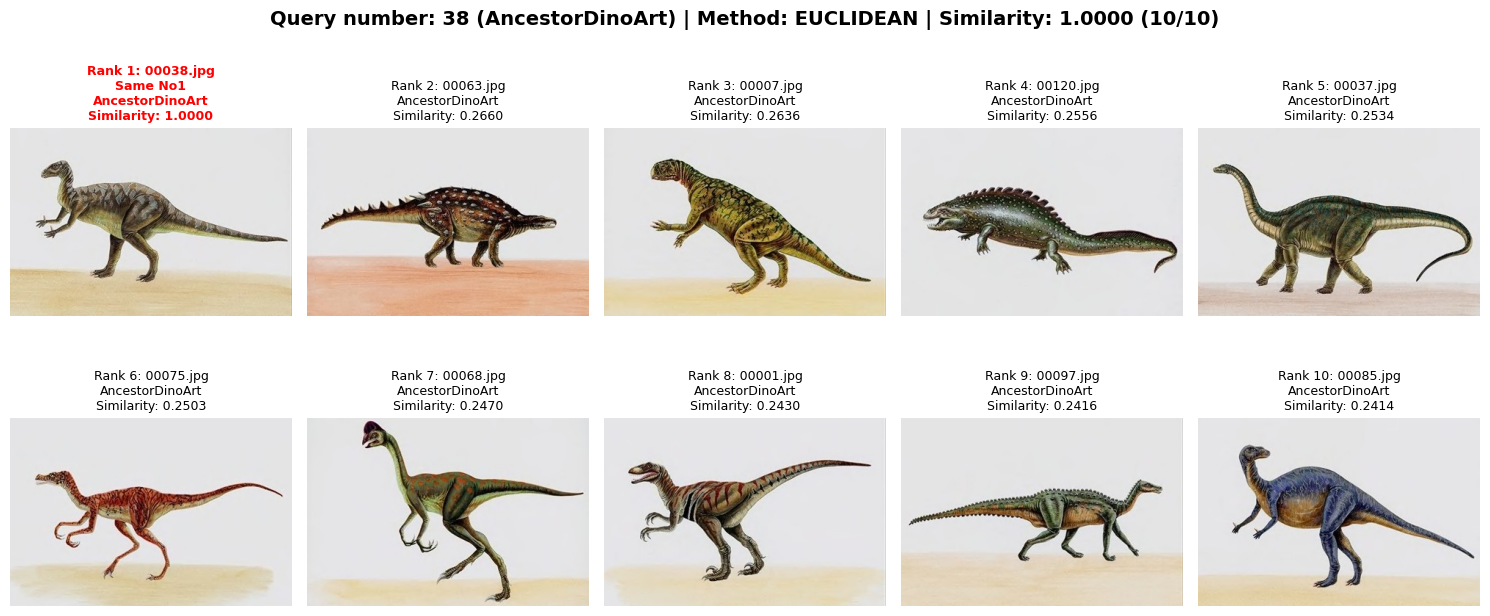

成功載入 10/10 張圖片
圖片視窗已顯示，關閉視窗後可繼續查詢

請輸入要查詢的圖片編號 (例如: 9771)，或輸入 Q 退出:
錯誤：請輸入有效的數字或 Q 退出

請輸入要查詢的圖片編號 (例如: 9771)，或輸入 Q 退出:

感謝使用！再見！

程式結束！


In [1]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
from time import time
import cv2

class ImageRetrievalSystem:
    def __init__(self, data_dir, is_normalized=True):
        """
        初始化圖像檢索系統
        data_dir: 資料目錄路徑
        is_normalized: True 使用正規化資料，False 使用非正規化資料
        """
        self.data_dir = data_dir
        self.is_normalized = is_normalized
        self.features = []
        self.labels = []
        self.image_paths = []
        self.feature_ranges = {
            'ColorStructure': (0, 32),
            'ColorLayout': (32, 44),
            'RegionShape': (44, 80),
            'HomogeneousTexture': (336, 398),
            'EdgeHistogram': (398, 478)
        }
        
    def load_data(self):
        """載入所有特徵檔案"""
        print(f"載入{'正規化' if self.is_normalized else '非正規化'}資料...")
        
        txt_files = [f for f in os.listdir(self.data_dir) if f.endswith('.txt')]
        
        image_counter = 1  # 從1開始計數
        
        for txt_file in txt_files:
            class_name = txt_file.replace('.txt', '')
            file_path = os.path.join(self.data_dir, txt_file)
            
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 478:
                    continue
                
                features = np.array([float(x) for x in parts[:478]])
                # 使用編號作為圖片檔名，格式: 05位數.jpg
                image_filename = f"{image_counter:05d}.jpg"
                
                self.features.append(features)
                self.labels.append(class_name)
                self.image_paths.append(image_filename)
                
                image_counter += 1
        
        self.features = np.array(self.features)
        print(f"載入完成: {len(self.features)} 張圖像")
        

    def query_and_display_images(self, query_position, image_base_dir, method='cosine', show_top_n=10):
        """
        查詢指定位置的圖片，並顯示相似度最高的前 N 張圖片
        
        參數:
            query_position: 圖片順位 (1-based, 例如 500)
            image_base_dir: 圖片基礎目錄 (如: "C:\\...\\ALL_PIC")
            method: 相似度計算方法
            show_top_n: 顯示前 n 個最相似的圖像（包含自己）
        """
        
        query_idx = query_position - 1  # 轉換為 0-based 索引
        
        if query_idx < 0 or query_idx >= len(self.features):
            print(f"錯誤：圖片順位 {query_position} 超出範圍 (1-{len(self.features)})")
            return
        
        query_label = self.labels[query_idx]
        query_filename = self.image_paths[query_idx]
        
        print(f"\n查詢圖像編號: {query_position}")
        print(f"類別: {query_label}")
        print(f"檔案名稱: {query_filename}")
        print(f"相似度計算方法: {method}")
        
        # 檢查圖片目錄
        if not os.path.exists(image_base_dir):
            print(f"錯誤：目錄不存在！{image_base_dir}")
            return
        
        # 計算相似度矩陣
        print("計算相似度中...")
        start_time = time()
        if method == 'cosine':
            similarity_matrix = cosine_similarity(self.features)
        elif method == 'euclidean':
            distance_matrix = euclidean_distances(self.features)
            similarity_matrix = 1 / (1 + distance_matrix)
        elif method == 'pcc':
            similarity_matrix = np.corrcoef(self.features)
            similarity_matrix = np.nan_to_num(similarity_matrix, 0)
        print(f"完成！耗時: {time() - start_time:.2f} 秒")
        
        # 取得相似度分數（包含自己）
        scores = similarity_matrix[query_idx].copy()
        
        # 找出最相似的前 show_top_n 張（包含自己）
        top_n_indices = np.argsort(scores)[-show_top_n:][::-1]
        
        print(f"\n最相似的前 {show_top_n} 張圖片（包含查詢圖片）:")
        print("-"*70)
        
        # 顯示結果
        for rank, idx in enumerate(top_n_indices, 1):
            is_query = " 查詢圖片" if idx == query_idx else ""
            print(f"{rank:2d}. 編號:{self.image_paths[idx]:<12} | 類別:{self.labels[idx]:<30} | 相似度:{scores[idx]:.6f}{is_query}")
        
        # 計算準確率
        correct = sum(1 for idx in top_n_indices if self.labels[idx] == query_label)
        accuracy = correct / show_top_n
        print("-"*70)
        print(f"準確率: {accuracy:.4f} ({correct}/{show_top_n} 張圖片與查詢圖片同類別)")
        print("-"*70)
        
        # 使用 matplotlib 顯示圖片
        print("\n正在載入圖片...")
        
        # 計算子圖佈局
        n_cols = min(5, show_top_n)
        n_rows = (show_top_n + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3.5))
        if show_top_n == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        loaded_count = 0
        for rank, idx in enumerate(top_n_indices):
            img_filename = self.image_paths[idx]
            full_path = os.path.join(image_base_dir, img_filename)
            
            ax = axes[rank]
            
            if os.path.exists(full_path):
                img = cv2.imread(full_path)
                if img is not None:
                    # OpenCV 讀取的是 BGR，轉換為 RGB
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    ax.imshow(img_rgb)
                    
                    is_query = "\nSame No1" if idx == query_idx else ""
                    title = f"Rank {rank+1}: {img_filename}{is_query}\n{self.labels[idx]}\nSimilarity: {scores[idx]:.4f}"
                    ax.set_title(title, fontsize=9, fontweight='bold' if idx == query_idx else 'normal', 
                                color='red' if idx == query_idx else 'black')
                    ax.axis('off')
                    loaded_count += 1
                else:
                    ax.text(0.5, 0.5, f'無法讀取\n{img_filename}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f'檔案不存在\n{img_filename}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        # 隱藏多餘的子圖
        for idx in range(show_top_n, len(axes)):
            axes[idx].axis('off')
        
        # 在圖片視窗標題顯示準確率
        fig.suptitle(f'Query number: {query_position} ({query_label}) | Method: {method.upper()} | Similarity: {accuracy:.4f} ({correct}/{show_top_n})', 
                     fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"成功載入 {loaded_count}/{show_top_n} 張圖片")
        print("圖片視窗已顯示，關閉視窗後可繼續查詢")
        
        return top_n_indices, scores[top_n_indices]
    


# 主程式
if __name__ == "__main__":
    # 設定路徑
    normalized_dir = r"output_txt\normalized"
    image_base_dir = r"ALL_PIC"
    
    # 載入系統
    system = ImageRetrievalSystem(normalized_dir, is_normalized=True)
    system.load_data()
    
    print("\n" + "="*70)
    print("圖像檢索系統")
    print("="*70)
    print(f"總共載入 {len(system.features)} 張圖像")
    print(f"類別數: {len(set(system.labels))}")
    print("="*70)
    
    # 無窮迴圈讓使用者持續查詢
    while True:
        print("\n請輸入要查詢的圖片編號 (例如: 9771)，或輸入 Q 退出:")
        user_input = input(">>> ").strip()
        
        # 檢查是否要退出
        if user_input.upper() == 'Q':
            print("\n感謝使用！再見！")
            break
        
        # 檢查輸入是否為數字
        try:
            query_position = int(user_input)
        except ValueError:
            print("錯誤：請輸入有效的數字或 Q 退出")
            continue
        
        # 檢查範圍
        if query_position < 1 or query_position > len(system.features):
            print(f"錯誤：圖片編號必須在 1 到 {len(system.features)} 之間")
            continue
        
        # 讓用戶選擇相似度計算方法
        print("\n請選擇相似度計算方法:")
        print("1. Cosine (餘弦相似度)")
        print("2. Euclidean (歐式距離)")
        print("3. PCC (皮爾森相關係數)")
        method_input = input("請輸入選項 (1/2/3): ").strip()
        
        # 根據選擇設定方法
        if method_input == '1':
            method = 'cosine'
        elif method_input == '2':
            method = 'euclidean'
        elif method_input == '3':
            method = 'pcc'
        else:
            print("錯誤：無效的選項，使用預設方法 (Cosine)")
            method = 'cosine'
        
        # 執行查詢並顯示結果
        print("\n" + "="*70)
        system.query_and_display_images(
            query_position=query_position,
            image_base_dir=image_base_dir,
            method=method,
            show_top_n=10
        )
        print("="*70)
    
    print("\n程式結束！")